In [1]:
from xpol import *
import numpy as np
import proplot as plot
import os
import shapely
import cartopy

# radar position
position = (-27.00743, 150.4389)
rpoint = shapely.geometry.Point(position[::-1])
aeqd = cartopy.crs.AzimuthalEquidistant(central_longitude=position[1], central_latitude=position[0])


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [5]:
dirr = '/media/meso/E77E-5B61/'
volumes = get_volumes_from_dir(dirr)#, start = pd.to_datetime('2023-10-25 02:00:00'), end = pd.to_datetime('2023-10-25 08:00:00'))
print(volumes)
for files in tqdm(volumes[:]):
    radar = scans_to_volume(files, position = position, azimuth = 0)
    fn = 'xpol_' + '_'.join(files[0].split('/')[-1].split('_')[slice(1,3)])+'_vol.nc'
    pyart.io.write_cfradial(dirr + fn, radar)

[['/media/meso/E77E-5B61//0021_20231026_021300_01_02.scn', '/media/meso/E77E-5B61//0021_20231026_021300_02_02.scn', '/media/meso/E77E-5B61//0021_20231026_021300_03_02.scn', '/media/meso/E77E-5B61//0021_20231026_021300_04_02.scn']]


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


In [6]:
radars = sorted([dirr+i for i in os.listdir(dirr) if i[-2:] == 'nc'])
print(radars[-1])
radar = pyart.io.read(radars[-1])
radar.add_field('SNR', pyart.retrieve.calculate_snr_from_reflectivity(radar, refl_field = 'DBZH'))
#radar.fields['DBZH']['data'] = np.ma.masked_array(radar.fields['DBZH']['data'], radar.fields['SNR']['data'] < 2)

/media/meso/E77E-5B61/xpol_20231026_021300_vol.nc


/home/meso/miniforge3/envs/uqxpol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/meso/miniforge3/envs/uqxpol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/meso/miniforge3/envs/uqxpol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/meso/miniforge3/envs/uqxpol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

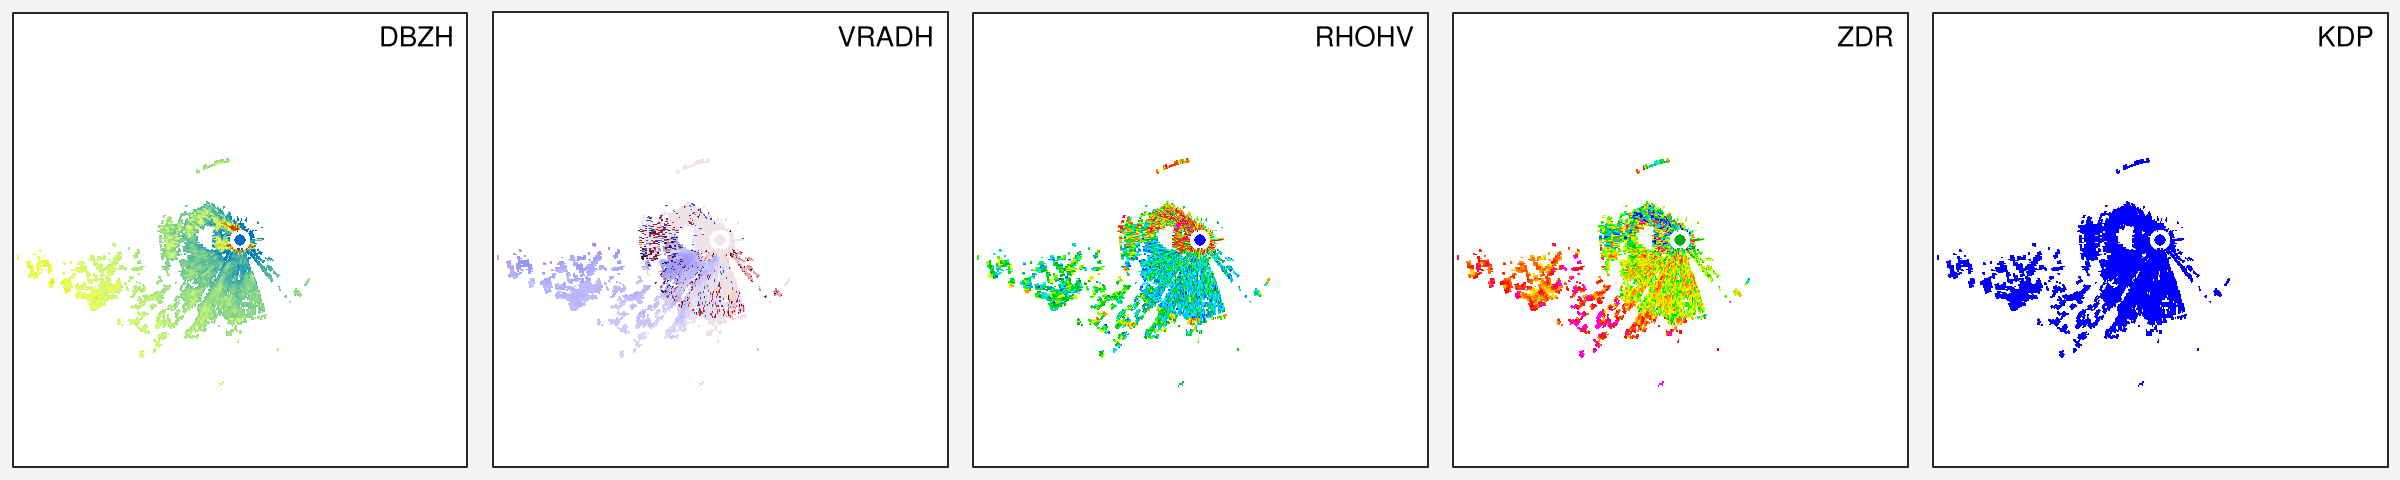

In [13]:
kwargs = {'DBZH': dict(vmin = 0, vmax = 50, cmap = 'pyart_homeyerrainbow', discrete = False, edgecolor = 'none'),
          'VRADH': dict(vmin = -20, vmax = 20, cmap = 'BR', discrete = False, edgecolor = 'none'),
          'RHOHV': dict(vmin = 0, vmax = 1, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none'),
          'ZDR': dict(vmin = -5, vmax = 10, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none'),
          'KDP': dict(vmin = 0, vmax = 10, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none'),
          'WRADH': dict(vmin = 0, vmax = 4, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none'),
          'SNR': dict(vmin = 2, vmax = 5, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none'),
         }


tilt, tilt2, fields = 3, 12, ['DBZH', 'VRADH', 'RHOHV', 'ZDR', 'KDP']


xr, yr, zr = radar.get_gate_x_y_z(tilt)
#xr2, yr2, zr2 = radar2.get_gate_x_y_z(tilt2)

rmask = np.zeros(radar.get_field(tilt, 'DBZH').shape)
rmask = ((radar.get_field(tilt, 'SNR') < 2))

N = len(fields)
fig, axs = plot.subplots(ncols = N, nrows = 1, width = 12, wspace = 1, proj = aeqd)

lim = 1e4
for ax in axs:
    ax.set_extent(np.array([-1,1,-1,1])*lim, crs = aeqd)
    #coast.to_crs(aeqd).plot(ax = ax, ec = 'none', fc = 'powder blue')
    #mainland.to_crs(aeqd).plot(ax = ax, ec=  'none', fc= 'bisque')
    # mainland.to_crs(aeqd).plot(ax = ax, ec=  'k', fc= 'none', zorder = 3)
    # rpoints.plot(ax = ax, fc = 'k', marker = '^', zorder = 3)
    # rpoints.iloc[0:1].to_crs(aeqd).buffer(25000).plot(ax = ax, fc= 'none', ec = 'k', ls = '--', zorder = 3)


for i, field in enumerate(fields):

    axs[i].format(title = field, titleloc = 'ur')
    rfield = np.ma.masked_array(radar.get_field(tilt, field), rmask)
    axs[i].pcolormesh(xr, yr, rfield, transform = aeqd, **kwargs[field])

    #rfield = radar2.get_field(tilt2, field)
    #axs[i+N].pcolormesh(xr2, yr2, rfield, colorbar = 'b', colorbar_kw = dict(length = 1), transform = aeqd2, **kwargs[field])

#fig.save('/g/data/kl02/jb2354/UQXPOL/mtstap_comparison.png', dpi = 200)
plot.show()

In [33]:
radar.fixed_angle

{'long_name': 'Target angle for sweep',
 'units': 'degrees',
 'standard_name': 'target_fixed_angle',
 'data': masked_array(data=[2.],
              mask=False,
        fill_value=1e+20)}